**Exercise 5: Stochastic Gradient Descent**

*CPSC 381/581: Machine Learning*

*Yale University*

*Instructor: Alex Wong*

*Student: Hailey Robertson*

**Prerequisites**:

1. Enable Google Colaboratory as an app on your Google Drive account

2. Create a new Google Colab notebook, this will also create a "Colab Notebooks" directory under "MyDrive" i.e.
```
/content/drive/MyDrive/Colab Notebooks
```

3. Create the following directory structure in your Google Drive
```
/content/drive/MyDrive/Colab Notebooks/CPSC 381-581: Machine Learning/Exercises
```

4. Move the 05_exercise_stochastic_gradient_descent.ipynb into
```
/content/drive/MyDrive/Colab Notebooks/CPSC 381-581: Machine Learning/Exercises
```
so that its absolute path is
```
/content/drive/MyDrive/Colab Notebooks/CPSC 381-581: Machine Learning/Exercises/05_exercise_stochastic_gradient_descent.ipynb
```

In this exercise, we will test stochastic gradient descent (SGD) and gradient descent (GD) for linear regression. We will plot out the loss of each model, test the models on training, validation, and testing sets, and benchmark their training time.


**Submission**:

1. Implement all TODOs in the code blocks below.

2. Report your training, and validation/testing scores.

```
----- learning rate: 0.0010  batch size: 200 time elapsed: 1.1600s -----
Training set mean squared error: 4.0025
Training set r-squared scores: 0.9998
Validation set mean squared error: 3.9149
Validation set r-squared scores: 0.9998
Testing set mean squared error: 4.0267
Testing set r-squared scores: 0.9998
----- learning rate: 0.0010  batch size: 500 time elapsed: 1.2816s -----
Training set mean squared error: 4.0027
Training set r-squared scores: 0.9998
Validation set mean squared error: 3.9033
Validation set r-squared scores: 0.9998
Testing set mean squared error: 4.0123
Testing set r-squared scores: 0.9998
----- learning rate: 0.0010  batch size: 1000 time elapsed: 1.5139s -----
Training set mean squared error: 3.9928
Training set r-squared scores: 0.9998
Validation set mean squared error: 4.0048
Validation set r-squared scores: 0.9998
Testing set mean squared error: 3.9977
Testing set r-squared scores: 0.9998
----- learning rate: 0.0010  batch size: 10000 time elapsed: 8.8030s -----
Training set mean squared error: 3.9885
Training set r-squared scores: 0.9998
Validation set mean squared error: 3.9902
Validation set r-squared scores: 0.9998
Testing set mean squared error: 4.0198
Testing set r-squared scores: 0.9998
----- learning rate: 0.0010  batch size: 100000 time elapsed: 82.3447s -----
Training set mean squared error: 4.1706
Training set r-squared scores: 0.9998
Validation set mean squared error: 4.1117
Validation set r-squared scores: 0.9998
Testing set mean squared error: 4.2083
Testing set r-squared scores: 0.9998

```

3. List any collaborators.

```
Collaborators: N/A
```

Import packages

In [1]:
import numpy as np
import sklearn.datasets as skdata
import sklearn.metrics as skmetrics
import sklearn.preprocessing as skpreprocessing
from sklearn.linear_model import SGDRegressor
import time, warnings
import matplotlib.pyplot as plt

warnings.filterwarnings(action='ignore')
np.random.seed = 1

Define colors for display

In [2]:
# Create a list of colors for display
colors = [
    'tab:blue',
    'tab:green',
    'tab:red',
    'tab:orange',
    'tab:purple',
    'tab:brown',
    'tab:pink',
    'tab:gray',
    'tab:olive'
]

Override the partial_fit function

In [3]:
# MSE, output losses
# SGD Regressor is a skicit-learn class
# Doing this to control for batch size whereas SGD is an all-in-one package
class SGDRegressorMSEVerbose(SGDRegressor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Define a list to hold loss values after each update
        self.__losses = []

    # Modifying partial fit for small subset of data points
    def partial_fit(self, X, y, sample_weight=None, do_logging=False):
        '''
        Performs a single update ato the parameters

        Arg(s):
            X : numpy[float32]
                N x d feature vector
            y : numpy[float32]
                N targets
            sample_weight : numpy[float32]
                Weights applied to individual samples.
                If not provided, uniform weights are assumed.
                Set this to None
            do_logging : boolean
                If set to True then log the loss
        '''

        # Check if coefficients are allocated
        if getattr(self, "coef_", None) is None:

            # Allocate coefficients
            # Initialization
            self._allocate_parameter_mem(
                n_classes=1,
                n_features=X.shape[1],
                input_dtype=X.dtype,
                coef_init=np.zeros([X.shape[1]]),
                intercept_init=self.fit_intercept,
                one_class=True)

            self.intercept_ = self.offset_

        # If we are logging
        # Same concepts for a2
        if do_logging:
            # DONE: Make predictions on the training examples
            y_hat = self.predict(X)

            # DONE: Calculate loss (mean squared error)
            loss = skmetrics.mean_squared_error(y, y_hat)

            # DONE: Append loss to running loss
            self.__losses.append(loss)

        # DONE: Call partial_fit from parent class
        # Don't want to train on entire dataset (fit), partial fit is just a subset
        # super accesses parent class which has already defined partial fit function
        # don't worry about sample weight - just weighs different samples 
        # adaptivity
        super().partial_fit(X, y, sample_weight)
        


    def get_losses(self):
        '''
        Fetches the list of loss values

        Returns:
            list[float] : list of loss values
        '''

        return self.__losses

Loading data

In [4]:
# Create a large-scale synthetic dataset (considered "big" for purpose of this class)
X, y = skdata.make_regression(n_samples=100000, n_features=100, noise=2)

dataset_name = 'synthetic regression dataset'

Define hyperparameters

In [5]:
# DONE: Set batch sizes to be 200, 500, 1000, 10000, 100000 (gradient descent)
# At batch size around 10000 - orange and purple lines overlap (same loss as gradient descent but much faster)
# To make fast, shorten to 1000
dataset_batch_sizes = [
    200, 500, 1000, 10000, 100000
]

# DONE: Set learning schedules to be 'invscaling', 'invscaling', 'invscaling', 'invscaling', 'constant' (gradient descent)
# invscaling using polynomial decay
# constant just constant learning rate from gradient descent
# keep inverse scale if you want to be fast
dataset_learning_schedules = [
   'invscaling', 'invscaling', 'invscaling', 'invscaling', 'constant'
]

# Feel free to modify to gauge the behavior
learning_rate = 1e-3 # good
max_iteration = 1000 # enough to prove
logging_frequency = 10 # lets you see what the behavior is at finer steps

Training and validation loop

----- learning rate: 0.0010  batch size: 200 time elapsed: 1.1600s -----
Training set mean squared error: 4.0025
Training set r-squared scores: 0.9998
Validation set mean squared error: 3.9149
Validation set r-squared scores: 0.9998
Testing set mean squared error: 4.0267
Testing set r-squared scores: 0.9998
----- learning rate: 0.0010  batch size: 500 time elapsed: 1.2816s -----
Training set mean squared error: 4.0027
Training set r-squared scores: 0.9998
Validation set mean squared error: 3.9033
Validation set r-squared scores: 0.9998
Testing set mean squared error: 4.0123
Testing set r-squared scores: 0.9998
----- learning rate: 0.0010  batch size: 1000 time elapsed: 1.5139s -----
Training set mean squared error: 3.9928
Training set r-squared scores: 0.9998
Validation set mean squared error: 4.0048
Validation set r-squared scores: 0.9998
Testing set mean squared error: 3.9977
Testing set r-squared scores: 0.9998
----- learning rate: 0.0010  batch size: 10000 time elapsed: 8.8030s ---

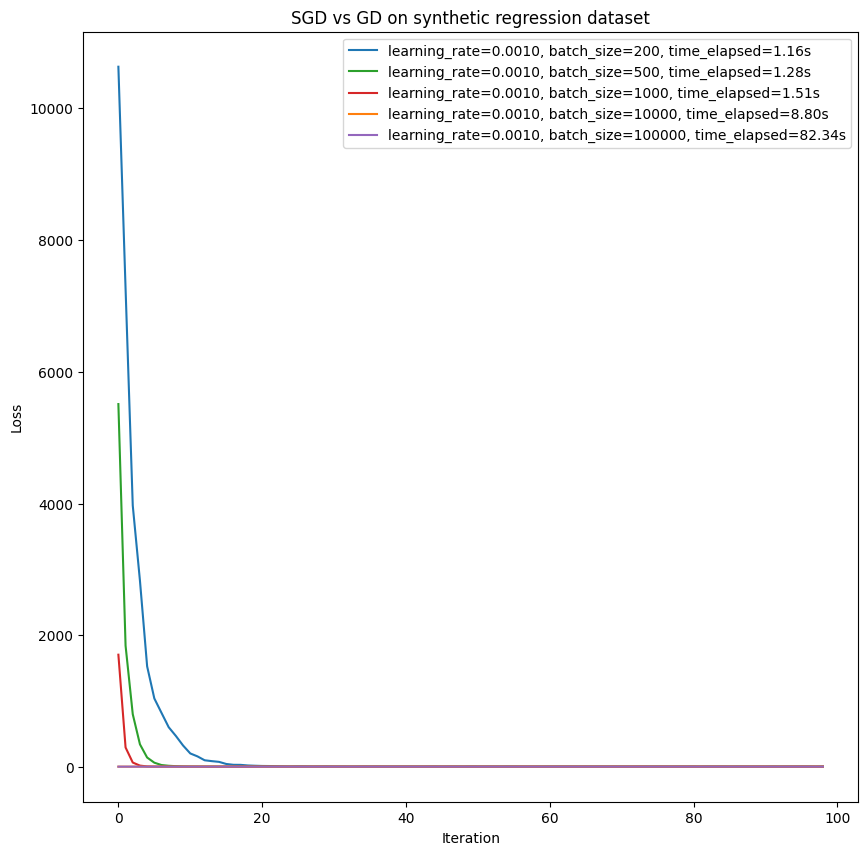

In [ ]:
# Define a dictionary to hold losses
train_losses = {}

for batch_size, learning_schedule in zip(dataset_batch_sizes, dataset_learning_schedules):

    '''
    Create the training, validation and testing splits
    '''

    # Shuffle the dataset based on sample indices
    shuffled_indices = np.random.permutation(X.shape[0])

    # Choose the first 80% as training set, next 10% as validation and the rest as testing
    train_split_idx = int(0.80 * X.shape[0])
    val_split_idx = int(0.90 * X.shape[0])

    train_indices = shuffled_indices[0:train_split_idx]
    val_indices = shuffled_indices[train_split_idx:val_split_idx]
    test_indices = shuffled_indices[val_split_idx:]

    # Select the examples from X and y to construct our training, validation, testing sets
    X_train, y_train = X[train_indices, :], y[train_indices]
    X_val, y_val = X[val_indices, :], y[val_indices]
    X_test, y_test = X[test_indices, :], y[test_indices]

    '''
    Train and validate linear regression on each dataset
    '''
    # DONE: Instantiate linear regression model using SGDRegressorMSEVerbose with
    # loss='squared_error', penalty=None, alpha=0.0, learning_rate=learning_schedule, eta0=learning_rate
    model_scikit = SGDRegressorMSEVerbose(
            loss='squared_error', 
            penalty=None,                       # regularizer (covered later)
            alpha=0.0,                          # weighting factor of how much to emphasize regularizer (labmda in lecture)
            learning_rate=learning_schedule,    # our learning schedule
            eta0=learning_rate                  # our set rate
            )

    # DONE: Mark the starting time (aka, mark current time)
    time_start = time.time()

    # Iterate through the number of iterations
    for iteration in range(max_iteration):

        # DONE: Sample batch size number of examples from the training set
        batch_indices = np.random.permutation(X_train.shape[0])[0:batch_size]
        X_train_batch = X_train[batch_indices, :]
        y_train_batch = y_train[batch_indices]

        # DONE: Check if we will log
        # Don't want to log on initial iteration, so we want to say iteration > 0 so we don't log at high loss
        do_logging = iteration > 0 and (iteration % logging_frequency == 0)

        # DONE: Perform a single update using the batch
        # skipping sample weight so specifying do_logging
        model_scikit.partial_fit(X_train_batch, y_train_batch, do_logging=do_logging)


    # DONE: Compute the time elapse
    time_elapsed = time.time() - time_start

    # DONE: Get losses logged within the model
    losses = model_scikit.get_losses()

    # DONE: Set losses as value to the key (learning_rate, batch_size, time_elapsed)
    train_losses[(learning_rate, batch_size, time_elapsed)] = losses


    print('----- learning rate: {:.4f}  batch size: {} time elapsed: {:.4f}s -----'.format(
        learning_rate, batch_size, time_elapsed))

    # DONE: Test model on training set
    predictions_train = model_scikit.predict(X_train)

    score_mse_train = skmetrics.mean_squared_error(y_train, predictions_train)
    print('Training set mean squared error: {:.4f}'.format(score_mse_train))

    score_r2_train = skmetrics.r2_score(y_train, predictions_train)
    print('Training set r-squared scores: {:.4f}'.format(score_r2_train))

    # DONE: Test model on validation set
    predictions_val = model_scikit.predict(X_val)

    score_mse_val = skmetrics.mean_squared_error(y_val, predictions_val)
    print('Validation set mean squared error: {:.4f}'.format(score_mse_val))

    score_r2_val = skmetrics.r2_score(y_val, predictions_val)   
    print('Validation set r-squared scores: {:.4f}'.format(score_r2_val))

    # DONE: Test model on testing set
    predictions_test = model_scikit.predict(X_test)

    score_mse_test = skmetrics.mean_squared_error(y_test, predictions_test) 
    print('Testing set mean squared error: {:.4f}'.format(score_mse_test))

    score_r2_test = skmetrics.r2_score(y_test, predictions_test)    
    print('Testing set r-squared scores: {:.4f}'.format(score_r2_test))

# DONE: Create figure of figsize=(10, 10)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

# Iterate through losses
for (key, losses), c in zip(train_losses.items(), colors):

    # DONE: Unpack key as learning_rate, batch_size, time_elapsed
    learning_rate, batch_size, time_elapsed = key


    # DONE: Plot iterations (x-axis), losses (y-axis), with label of 'learning_rate={:.4f}, batch_size={}, time_elapsed={:.2f}s', and color c
    ax.plot(losses, label='learning_rate={:.4f}, batch_size={}, time_elapsed={:.2f}s'.format(
        learning_rate, batch_size, time_elapsed), color=c)


    # DONE: Set title as 'SGD vs GD on synthetic regression dataset'
    plt.title('SGD vs GD on synthetic regression dataset')

    # DONE: Set xlabel as 'Iteration'
    plt.xlabel('Iteration')


    # DONE: Set ylabel as 'Loss'
    plt.ylabel('Loss')

    # DONE: Show legend
    plt.legend()

# Show plots
plt.show()
